In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Installing Required Packages:**

In [2]:
!pip install gdown
!pip install opencv-python[all]

  Obtaining dependency information for gdown from https://files.pythonhosted.org/packages/cb/56/f4845ed78723a4eb8eb22bcfcb46e1157a462c78c0a5ed318c68c98f9a79/gdown-5.1.0-py3-none-any.whl.metadata


**Importing Packages and Designing the Algorithm:**

In [23]:
import cv2
import numpy as np
import gdown
from scipy.signal import find_peaks, savgol_filter
from scipy.ndimage.filters import uniform_filter1d
import matplotlib.pyplot as plt
import time

class Ball:
    def __init__(self):
        self.y_coordinates = []

def download_video(url, output):
    try:
        gdown.download(url, output, quiet=False)
    except Exception as e:
        print(f"Failed to download video: {e}")
        return False
    return True

def detect_dribbles(video_path):
    ball = Ball()

    # Define the lower and upper boundaries of the "yellow" in the HSV color space
    yellowLower = np.array([20, 100, 100])
    yellowUpper = np.array([30, 255, 255])

    # Load the video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Failed to open video file")
        return

    # Loop over each frame
    start_time = time.time()
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the frame to the HSV color space
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Construct a mask for the color "yellow", then perform a series of dilations and erosions to remove any small blobs left in the mask
        mask = cv2.inRange(hsv, yellowLower, yellowUpper)
        mask = cv2.erode(mask, None, iterations=2)
        mask = cv2.dilate(mask, None, iterations=2)

        # Find contours in the mask and initialize the current (x, y) center of the ball
        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
        center = None

        # Only proceed if at least one contour was found
        if len(cnts) > 0:
            # Find the largest contour in the mask, then use it to compute the minimum enclosing circle and centroid
            c = max(cnts, key=cv2.contourArea)
            ((x, y), radius) = cv2.minEnclosingCircle(c)
            M = cv2.moments(c)
            center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

            # Only proceed if the radius meets a minimum size
            if radius > 10:
                # Add the y-coordinate of the center of the ball to the list
                ball.y_coordinates.append(center[1])
                frame_count += 1

    # Calculate the frame rate of the video
    end_time = time.time()
    frame_rate = frame_count / (end_time - start_time)

    # Smooth the y-coordinate data more aggressively
    smoothed_y = savgol_filter(ball.y_coordinates, 51, 3)  # Increased window size and polynomial order

    # Find the peaks in the smoothed y-coordinate list
    peaks, _ = find_peaks(smoothed_y, distance=2)  # Decreased from 5.5 to 2

    # Print the total dribble count
    print('Dribbles:', len(peaks))

    # Calculate and print the average height of the dribbles
    average_height = np.mean(smoothed_y[peaks])
    print('Average height:', average_height)

    # Calculate and print the average time between dribbles
    average_time = np.mean(np.diff(peaks)) / frame_rate
    print('Average time between dribbles:', average_time, 'seconds')

    # Plot the y-coordinates and the detected peaks
    plt.plot(smoothed_y)
    plt.plot(peaks, smoothed_y[peaks], 'x')
    plt.show()

    # Release the video file
    cap.release()

**Running the algorithm and visualizing the results:**

Downloading...
From: https://drive.google.com/uc?id=1DNgTttDyS26NW5SGtiN90jCFN1osXI4V
To: /kaggle/working/video.mp4
100%|██████████| 12.7M/12.7M [00:00<00:00, 248MB/s]


Dribbles: 102
Average height: 518.1801008971244
Average time between dribbles: 0.05458825546326023 seconds


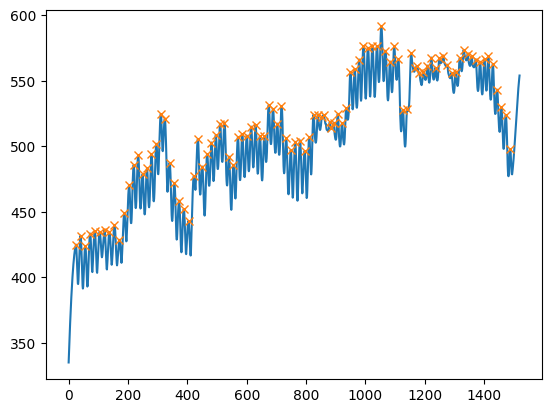

In [24]:
# Download the video from Google Drive
url = 'https://drive.google.com/uc?id=1DNgTttDyS26NW5SGtiN90jCFN1osXI4V'
output = 'video.mp4'
if download_video(url, output):
    detect_dribbles(output)